In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from tqdm import tqdm
import cv2

characters = np.load('character_font.npz')['images']

In [157]:
class Encoder(nn.Module):

  def __init__(self, seed_size, img_channel):

    super(Encoder, self).__init__()
    self.encoder = nn.Sequential(

        nn.Conv2d(img_channel, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.mu_fc = nn.Conv2d(512, seed_size, 2, 1, 0, bias=False)
    self.sigma_fc = nn.Conv2d(512, seed_size, 2, 1, 0, bias=False)
    self.kl = 0

  def forward(self,input,N):
    encoded = self.encoder(input)
    mu = self.mu_fc(encoded).mean([-2,-1])
    sigma = torch.exp(self.sigma_fc(encoded).mean([-2,-1]))
    z = mu + sigma*N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z

class Decoder(nn.Module):

  def __init__(self, seed_size, img_channel):

    super(Decoder, self).__init__()

    self.conv_transpose_block_1 = nn.Sequential(
        nn.ConvTranspose2d(seed_size, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True)) 
    
    self.conv_transpose_block_2 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True)) 

    self.conv_transpose_block_3 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True)) 

    self.conv_transpose_block_4 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True)) 

    self.conv_transpose_block_5 = nn.Sequential(
        nn.ConvTranspose2d(64, img_channel, 1, 1, 0, bias=False),
        nn.Sigmoid())

  def forward(self, input):
    input = self.conv_transpose_block_1(input)
    input = self.conv_transpose_block_2(input)
    input = self.conv_transpose_block_3(input)
    input = self.conv_transpose_block_4(input)
    input = self.conv_transpose_block_5(input)
    return input

class Discriminator(nn.Module):

  def __init__(self, img_channel, num_classes):

    super(Discriminator, self).__init__()
    self.block = nn.Sequential(

        nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(32, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
    )

    self.dis_out = nn.Conv2d(512, 1, 1, 1, 0, bias=False)
    self.pred = nn.Sequential(
        nn.Conv2d(512, num_classes, 1, 1, 0, bias=False),
        nn.Softmax(dim=1)
    )

  def forward(self,input):
    x = self.block(input)
    return self.dis_out(x), self.pred(x)

def plotter(images):
  f = -(-len(images)//3)
  fig,ax = plt.subplots(3,f,figsize=(5*f, 15))
  for i in range(len(images)):
    ax[i%3,i//3].imshow(images[i,0])
  for aa in ax:
    for aaa in aa:
      aaa.axis("off")
  plt.show()

def get_one_hot(a, maximum=25):
  b = np.zeros((a.size, maximum + 1))
  b[np.arange(a.size), a] = 1
  return b

seed_size = 128
num_class = 26
img_ch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc = Encoder(seed_size, img_ch).to(device)
gen = Decoder(seed_size+num_class, img_ch).to(device)
dis = Discriminator(img_ch, num_class).to(device)
gen.load_state_dict(torch.load('gen.pt',map_location=device))
dis.load_state_dict(torch.load('dis.pt',map_location=device))
enc.load_state_dict(torch.load('enc.pt',map_location=device))
N = torch.distributions.Normal(torch.tensor(0).float().to(device), torch.tensor(1).float().to(device))

@torch.no_grad()
def get_latent(img):
    if img is not None:
        enc.eval()
        latent = enc(torch.tensor(img).float().to(device), N)
        return latent[0].cpu().reshape(1,-1)
    else:
        return torch.randn(1, seed_size).to(device)

@torch.no_grad()
def get_demo(latent):
    gen.eval()
    visualize_noise = latent
    visualize_noise = torch.cat([visualize_noise for _ in range(num_class)], axis=0)
    onehot = torch.tensor(get_one_hot(np.arange(num_class)))
    visualize_noise = torch.cat([visualize_noise,onehot],axis=1).reshape(num_class,-1,1,1)
    pred = gen(visualize_noise.float())
    return pred
    
@torch.no_grad()
def get_predictions(text, latent):
    gen.eval()
    order = []
    for i in text.upper():
        o = ord(i)-65 
        if o < 0 or 0 > 25:
            order.append(26)
        else:
            order.append(o)
    onehot = torch.tensor(get_one_hot(np.array(order), 26)[:,:26])
    visualize_noise = torch.cat([latent for _ in range(len(onehot))],axis=0)
    visualize_noise = torch.cat([visualize_noise,onehot],axis=1).reshape(len(onehot),-1,1,1)
    pred = gen(visualize_noise.float())
    for i, num in enumerate(order):
        if num == 26:
            pred[i] = 0*pred[i]
    return pred

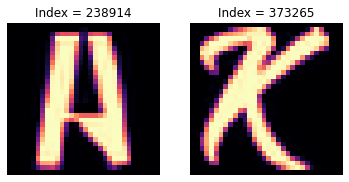

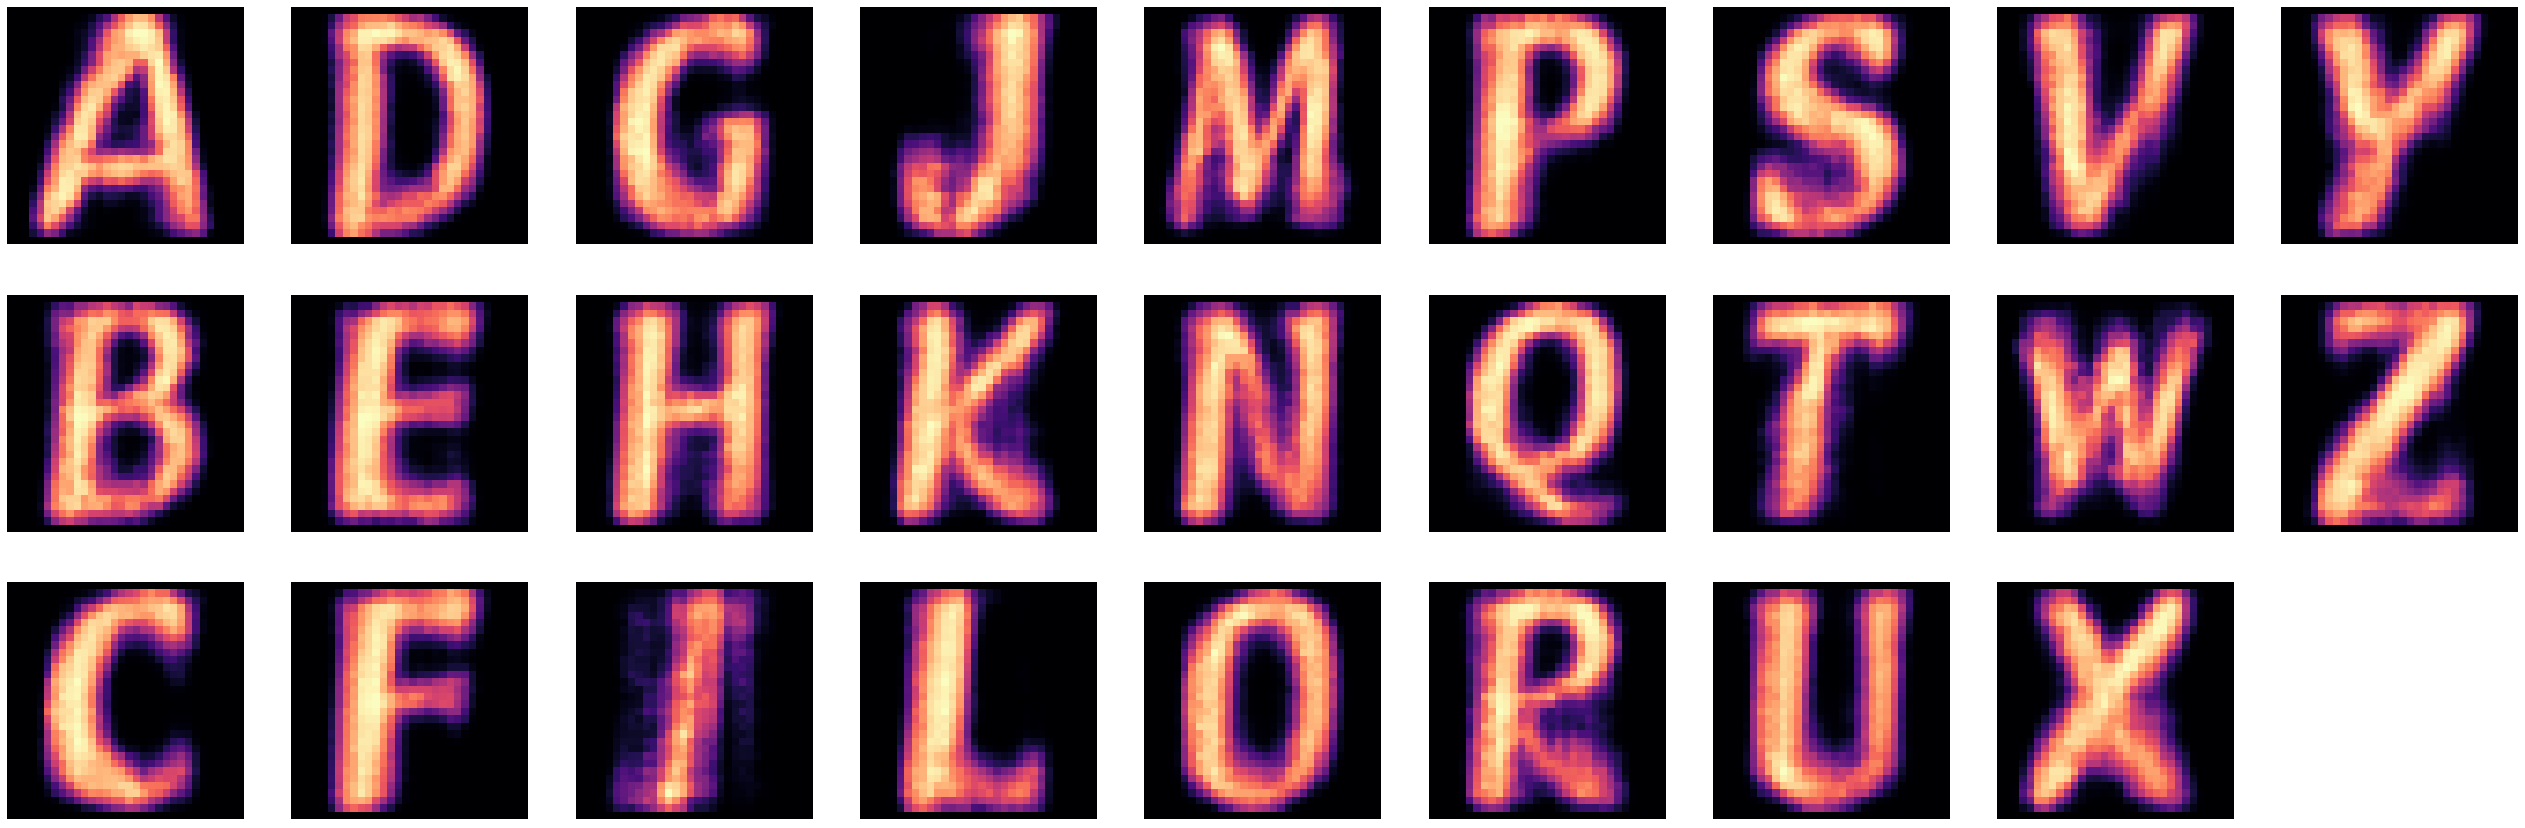

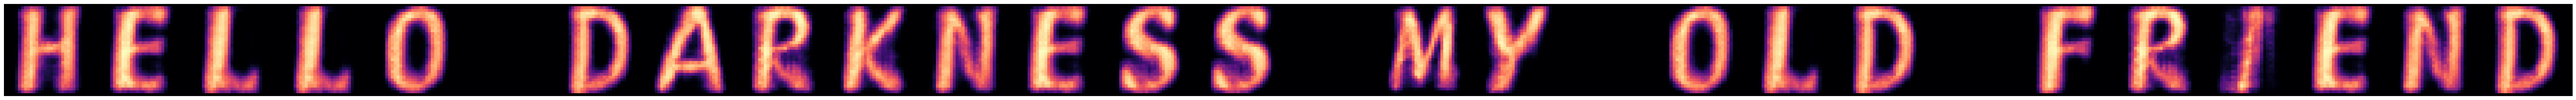

In [327]:
import matplotlib as mpl
mpl.rc('image', cmap='magma')

n = 2
idx = np.random.choice(np.arange(characters.shape[0]), n, replace=False)
fig, ax = plt.subplots(1,n,figsize=(n*3,3))
images = []
for i, j in enumerate(idx):
    ax[i].set_title(f"Index = {j}")
    img = characters[j].reshape(1,1,32,32)/255
    images.append(img)
    ax[i].imshow(img[0,0])
    ax[i].axis('off')

with torch.no_grad():
    latent = sum([get_latent(im) for im in images])/n
    pred = get_demo(latent)
    plotter(pred.cpu())
    pred = get_predictions("Hello darkness my old friend", latent)
    plt.figure(figsize=(len(pred)*3,3))
    plt.imshow(np.concatenate(list(pred.cpu().numpy()),axis=2)[0])
    plt.axis('off')
    plt.show()